# **Training Notebook (NovaSBE X GregoryAI)**

![Description of the image](../images/train_tune_pipeline_diagram.png)

## 1. Import libraries

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings

#supress warnings
warnings.filterwarnings("ignore")

# Add the parent directory of code_utils to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

from code_utils.text_utils import *  # Import everything from text_utils.py
from code_utils.model_utils.LSTM_algorithm_utils import *  
from code_utils.model_utils.BERT_algorithm_utils import *  
from code_utils.model_utils.LGBM_algorithm_utils import *  
from code_utils.model_utils.classify_model_choose import *
from code_utils.download_utils import * 
from code_utils.pseudo_utils.utils_pseudo import *
from code_utils.summarization_utils import *

## 2. Clean and Preprocess

In [3]:
dataset_path = os.path.join('../data/articles_08-06-2024_14h13m04s.csv')
# additional step to ensure consistency in the index column formating as article_id
articles_df = pd.read_csv(dataset_path)

# if the first column is not article_id, remove that first column

if articles_df.columns[0] != 'article_id':
    articles_df = articles_df.drop(columns=articles_df.columns[0])

articles_clean_df = load_and_format_dataset(dataset_path, text_cleaning_pd_series)

articles_clean_df.head()

,text_processed,relevant
article_id,,
1,covid19 hhv6 mog antibody perfect storm j neur...,0
2,migraine associated brain anatomical alteratio...,0
3,patient satisfaction quality counseling provid...,0
4,rare case spinal neurosarcoidosis concomitant ...,unlabeled
5,evaluation urinary tract infection following c...,0


In [ ]:
articles_clean_df.relevant.value_counts()

relevant
unlabeled    22050
0             1532
1             1008
Name: count, dtype: int64

## 3. Data Split into train, validation and test sets

In [4]:
# let's divide thr articles_clean_df into labelled and unlabelled data

unlabelled_df = articles_clean_df[articles_clean_df.relevant == 'unlabeled']
labelled_df = articles_clean_df[articles_clean_df.relevant != 'unlabeled']

In [5]:
relevant_column = 'relevant'

# First split: 85% train_val and 15% test
train_val_df, test_df = train_test_split(
    labelled_df,
    test_size=0.15,
    stratify=labelled_df[relevant_column],
    random_state=69
)

# Second split: ~88.235% train and ~11.765% val from train_val_df
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 of the original dataset
    stratify=train_val_df[relevant_column],
    random_state=69
)

# Verifying the splits
print("Train set distribution:")
print(train_df[relevant_column].value_counts(normalize=True))
print("\nValidation set distribution:")
print(val_df[relevant_column].value_counts(normalize=True))
print("\nTest set distribution:")
print(test_df[relevant_column].value_counts(normalize=True))

# Check the number of articles in each set
print(f"Number of articles in the training set: {len(train_df)}")
print(f"Number of articles in the validation set: {len(val_df)}")
print(f"Number of articles in the test set: {len(test_df)}")


Train set distribution:
relevant
0    0.603264
1    0.396736
Name: proportion, dtype: float64

Validation set distribution:
relevant
0    0.602094
1    0.397906
Name: proportion, dtype: float64

Test set distribution:
relevant
0    0.603675
1    0.396325
Name: proportion, dtype: float64
Number of articles in the training set: 1777
Number of articles in the validation set: 382
Number of articles in the test set: 381


## 4. Pseudo Labelling

Here you may choose to perform the Pseudo-Labelling task: 

Self-Training with a Traditional ML model (in this example we have LogisticRegression but you can test with others) 

Co-training approach (that is a diferent type of pseudolabelling that uses a combination of two traditional machine learning models), 

Or the BERT model uncased.

Our recomendation, to achieve best results, is BERT, but we understand it can be computer intensive and tricky to run.
Below you have the different sections for the different approaches.

### 4.1 Using BERT

First, let's check the distribution of the token length of the articles texts. By doing this we can check what's the optimal maximum lenght to use as a BERT parameter.

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

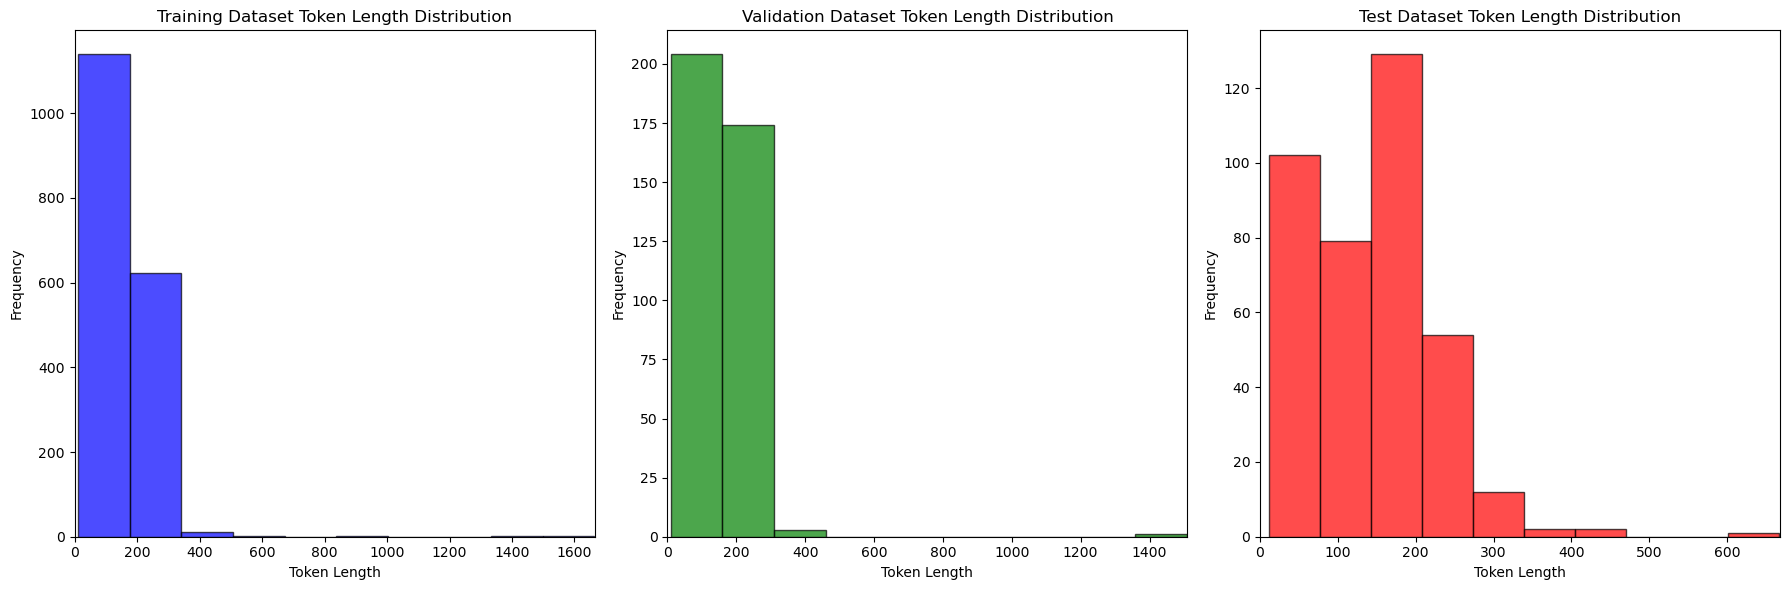

Training Dataset Token Length Distribution:
length_category
0-200        1381
200-400       387
400-600         5
600-800         0
800-1000        1
1000-1200       0
1200+           3
Name: count, dtype: int64

Validation Dataset Token Length Distribution:
length_category
0-200        303
200-400       78
400-600        0
600-800        0
800-1000       0
1000-1200      0
1200+          1
Name: count, dtype: int64

Test Dataset Token Length Distribution:
length_category
0-200        294
200-400       84
400-600        2
600-800        1
800-1000       0
1000-1200      0
1200+          0
Name: count, dtype: int64


In [ ]:
# initialize the BERT classifier
bert_classifier_pseudo = BERT_Classifier()

# use the dedicated function to calulate the token lenghts distribution
bert_classifier_pseudo.calculate_and_plot_token_lengths(train_df, val_df, test_df)

From the results of the distribution analysis we can see that 400 for max_len would be the optimal value. Since that would be a high computational demanding value, instead to set the max_len to a lower value, truncating, and resking leaving out valuable information, there's also the solution of performing a summarization of the text sequences (this way hopefully retaining a higher degree of information).

We leave that option here, in the cell below, in case the user wants to test this alternative, instead of simple truncation. 

We warn, however, that this process should take several hours to summarize every article text, and can be computational intensive since it uses the potetialities of transformers library.
Based on an experiment we performed, summarizing the text for 6000 articles, took 2 hours. So, the summarization of something like 25000 text inputs would take several hours, always depending on the resources of the machine used, off course.

### 4.1.1 With Summarization Option

In [ ]:
# Using the dedicated function we developed to summarize the texts

# we keep all parameters as default values, but you can change them if you want
text_summarization(train_df)
text_summarization(val_df)
text_summarization(test_df)

# See results, comparing the original text with the summary
print(train_df[['text_processed', 'summary']].head())
print(val_df[['text_processed', 'summary']].head())
print(test_df[['text_processed', 'summary']].head())

# [WARNING] This step can take several hourse to run

### 4.1.2 Without Summarization Option

In [ ]:
# choose max_lenght for BERT

max_len = 128 # optimal would be 400, but 128 chosen for computational reasons

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
labelled_train_df = train_df[['text_processed', 'relevant']]
val_df_pseudo = val_df[['text_processed', 'relevant']]
unlabelled_data_pseudo = unlabelled_df[['text_processed']]

final_labelled_train_df = bert_iterative_training(tokenizer, 
                                                  unlabelled_data_pseudo, 
                                                  labelled_train_df, 
                                                  val_df_pseudo, 
                                                  dense_units=48, 
                                                  learning_rate=1e-5, 
                                                  max_len=max_len, 
                                                  confidence_threshold=0.9, 
                                                  max_iterations=7)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8
112/112 - 43s - loss: 0.4646 - accuracy: 0.7845 - val_loss: 0.3901 - val_accuracy: 0.8220 - 43s/epoch - 382ms/step
Epoch 2/8
112/112 - 27s - loss: 0.2900 - accuracy: 0.8863 - val_loss: 0.3967 - val_accuracy: 0.8351 - 27s/epoch - 237ms/step
Epoch 3/8
112/112 - 27s - loss: 0.2167 - accuracy: 0.9178 - val_loss: 0.2715 - val_accuracy: 0.8927 - 27s/epoch - 239ms/step
Epoch 4/8
112/112 - 27s - loss: 0.1489 - accuracy: 0.9527 - val_loss: 0.3021 - val_accuracy: 0.9058 - 27s/epoch - 240ms/step
Epoch 5/8
112/112 - 27s - loss: 0.1076 - accuracy: 0.9657 - val_loss: 0.3429 - val_accuracy: 0.8927 - 27s/epoch - 241ms/step
Epoch 6/8
112/112 - 27s - loss: 0.0879 - accuracy: 0.9752 - val_loss: 0.3293 - val_accuracy: 0.8953 - 27s/epoch - 240ms/step
690/690 [==============================] - 96s 135ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8
1204/1204 - 286s - loss: 0.1736 - accuracy: 0.9310 - val_loss: 0.3657 - val_accuracy: 0.8796 - 286s/epoch - 238ms/step
Epoch 2/8
1204/1204 - 272s - loss: 0.0697 - accuracy: 0.9767 - val_loss: 0.4538 - val_accuracy: 0.8770 - 272s/epoch - 226ms/step
Epoch 3/8
1204/1204 - 273s - loss: 0.0416 - accuracy: 0.9864 - val_loss: 0.4145 - val_accuracy: 0.8953 - 273s/epoch - 227ms/step
Epoch 4/8
1204/1204 - 273s - loss: 0.0331 - accuracy: 0.9888 - val_loss: 0.4652 - val_accuracy: 0.8927 - 273s/epoch - 226ms/step
143/143 [==============================] - 22s 135ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8
1380/1380 - 327s - loss: 0.2078 - accuracy: 0.9110 - val_loss: 0.3493 - val_accuracy: 0.8874 - 327s/epoch - 237ms/step
Epoch 2/8
1380/1380 - 312s - loss: 0.0916 - accuracy: 0.9656 - val_loss: 0.3771 - val_accuracy: 0.9110 - 312s/epoch - 226ms/step
Epoch 3/8
1380/1380 - 313s - loss: 0.0594 - accuracy: 0.9787 - val_loss: 0.3564 - val_accuracy: 0.9058 - 313s/epoch - 227ms/step
Epoch 4/8
1380/1380 - 313s - loss: 0.0377 - accuracy: 0.9873 - val_loss: 0.4848 - val_accuracy: 0.9084 - 313s/epoch - 227ms/step
55/55 [==============================] - 10s 136ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8
1448/1448 - 342s - loss: 0.2314 - accuracy: 0.8980 - val_loss: 0.4380 - val_accuracy: 0.8822 - 342s/epoch - 236ms/step
Epoch 2/8
1448/1448 - 327s - loss: 0.1100 - accuracy: 0.9578 - val_loss: 0.3847 - val_accuracy: 0.8979 - 327s/epoch - 226ms/step
Epoch 3/8
1448/1448 - 328s - loss: 0.0658 - accuracy: 0.9767 - val_loss: 0.4794 - val_accuracy: 0.8953 - 328s/epoch - 227ms/step
Epoch 4/8
1448/1448 - 328s - loss: 0.0436 - accuracy: 0.9850 - val_loss: 0.4613 - val_accuracy: 0.9005 - 328s/epoch - 227ms/step
Epoch 5/8
1448/1448 - 328s - loss: 0.0357 - accuracy: 0.9867 - val_loss: 0.4866 - val_accuracy: 0.8953 - 328s/epoch - 226ms/step
21/21 [==============================] - 6s 137ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8
1474/1474 - 349s - loss: 0.2353 - accuracy: 0.8993 - val_loss: 0.3803 - val_accuracy: 0.8901 - 349s/epoch - 237ms/step
Epoch 2/8
1474/1474 - 334s - loss: 0.1129 - accuracy: 0.9574 - val_loss: 0.4181 - val_accuracy: 0.8953 - 334s/epoch - 226ms/step
Epoch 3/8
1474/1474 - 335s - loss: 0.0660 - accuracy: 0.9765 - val_loss: 0.4550 - val_accuracy: 0.9031 - 335s/epoch - 228ms/step
Epoch 4/8
1474/1474 - 334s - loss: 0.0464 - accuracy: 0.9839 - val_loss: 0.4861 - val_accuracy: 0.9031 - 334s/epoch - 227ms/step
8/8 [==============================] - 2s 152ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8
1482/1482 - 350s - loss: 0.2388 - accuracy: 0.8952 - val_loss: 0.3796 - val_accuracy: 0.8822 - 350s/epoch - 236ms/step
Epoch 2/8
1482/1482 - 336s - loss: 0.1156 - accuracy: 0.9549 - val_loss: 0.4122 - val_accuracy: 0.8979 - 336s/epoch - 227ms/step
Epoch 3/8
1482/1482 - 336s - loss: 0.0675 - accuracy: 0.9754 - val_loss: 0.4633 - val_accuracy: 0.8979 - 336s/epoch - 227ms/step
Epoch 4/8
1482/1482 - 335s - loss: 0.0481 - accuracy: 0.9829 - val_loss: 0.4835 - val_accuracy: 0.8953 - 335s/epoch - 226ms/step
4/4 [==============================] - 3s 139ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8
1484/1484 - 350s - loss: 0.2453 - accuracy: 0.8930 - val_loss: 0.3979 - val_accuracy: 0.8979 - 350s/epoch - 236ms/step
Epoch 2/8
1484/1484 - 335s - loss: 0.1212 - accuracy: 0.9522 - val_loss: 0.4107 - val_accuracy: 0.8848 - 335s/epoch - 226ms/step
Epoch 3/8
1484/1484 - 337s - loss: 0.0708 - accuracy: 0.9744 - val_loss: 0.4468 - val_accuracy: 0.8979 - 337s/epoch - 227ms/step
Epoch 4/8
1484/1484 - 340s - loss: 0.0497 - accuracy: 0.9818 - val_loss: 0.4928 - val_accuracy: 0.9031 - 340s/epoch - 229ms/step
3/3 [==============================] - 3s 133ms/step


INFO:tensorflow:Assets written to: models\pseudo_labelling\pseudo_bert_model\assets


INFO:tensorflow:Assets written to: models\pseudo_labelling\pseudo_bert_model\assets


Model saved to models\pseudo_labelling\pseudo_bert_model
Pseudo-labelled data saved to models\pseudo_labelling\pseudo_labels_bert.csv


### 4.2 Using Traditional ML + vectorizer (Self-Training)

If you aren't able to run BERT to perform the pseudolabelling, 
or just want a lighter version, this alternative is ideal.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer()
model = LogisticRegression()

labelled_train_df = train_df[['text_processed', 'relevant']]
val_df_pseudo = val_df[['text_processed', 'relevant']]
unlabelled_data_pseudo = unlabelled_df[['text_processed']]

pseudo_labels_self, _, _, _ = self_training(model, vectorizer, unlabelled_data_pseudo, labelled_train_df, val_df_pseudo, confidence_threshold=0.9)

## 5. Train the Model and Store Model Weights

Again, here you may choose from different options to train the data:

1 - BERT (Pubmed), pre-trained weights are already available to use in classification

2 - Backcup ML Model LGBM (Tfidf), pre-trained weights are already available to use in classification

3 - You can also easily implement the LSTM option, custom class with methods is provided in LSTM_algortithm.py file and pre-trained weights are already available to use in classification.

Our recomendation, to achieve best results, is BERT again, but we understand it can be computer intensive and tricky to run.
Below you have the different sections for the different approaches.

In [6]:
# First, let's import the dataset generated by the pseudo labelling process

pseudo_labelled_df = pd.read_csv('../models/pseudo_labelling/pseudo_labels_bert.csv', index_col = 0)
pseudo_labelled_df.index.name = 'article_id'
pseudo_labelled_df.head()

,text_processed,relevant,predicted_label,confidence
article_id,,,,
11468,parthenolide suppresses helper 17 alleviates e...,1,NaN,NaN
23015,immunosuppressive effects two probiotics lacto...,1,NaN,NaN
5101,diagnosis alzheimers disease related dementia ...,0,NaN,NaN
5,therapeutic targets fingolimod fty720 involved...,0,NaN,NaN
2040,demyelination remyelination detected alternati...,1,NaN,NaN


In [7]:
# let's keep the articles that:
# don't have a predicted_label (ones with real labels) 
# or don't have predicted label confidence >= 0.95

confidence_threshold = 0.95

pseudo_labelled_df = pseudo_labelled_df[
    (pseudo_labelled_df.predicted_label.isna()) | 
    (pseudo_labelled_df.confidence >= confidence_threshold)
]

In [8]:
train_df = pseudo_labelled_df

In [9]:
# drop the columns predicte_label and confidence from train_df

train_df = train_df.drop(columns=['predicted_label', 'confidence'])
train_df.head()

,text_processed,relevant
article_id,,
11468,parthenolide suppresses helper 17 alleviates e...,1
23015,immunosuppressive effects two probiotics lacto...,1
5101,diagnosis alzheimers disease related dementia ...,0
5,therapeutic targets fingolimod fty720 involved...,0
2040,demyelination remyelination detected alternati...,1


In [10]:
# fix index name of val_df and test_df to article_id
val_df.index.name = 'article_id'
test_df.index.name = 'article_id'

### BERT

In [13]:
bert_classifier = BERT_Classifier(max_len=max_len,
                                  bert_model_name='microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext',
                                  best_learning_rate=2e-05,
                                  best_dense_units=48,
                                  best_freeze_weights=False,
                                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])


# Encode the texts
X_train_ids, X_train_masks = bert_classifier.encode_texts(train_df['text_processed'].values)
X_val_ids, X_val_masks = bert_classifier.encode_texts(val_df['text_processed'].values)
X_test_ids, X_test_masks = bert_classifier.encode_texts(test_df['text_processed'].values)

# One-hot encode the labels
y_train = to_categorical(train_df['relevant'], num_classes=2)
y_val = to_categorical(val_df['relevant'], num_classes=2)
y_test = to_categorical(test_df['relevant'], num_classes=2)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

*** INITIALIZING MODEL TRAINING ***


Epoch 1/10
1288/1288 [==============================] - 311s 230ms/step - loss: 0.9787 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9631 - val_loss: 0.9104 - val_accuracy: 0.8979 - val_precision: 0.8979 - val_recall: 0.8979 - val_auc: 0.9537
Epoch 2/10
1288/1288 [==============================] - 294s 228ms/step - loss: 0.6104 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9871 - val_loss: 0.8086 - val_accuracy: 0.9031 - val_precision: 0.9031 - val_recall: 0.9031 - val_auc: 0.9493
Epoch 3/10
1288/1288 [==============================] - 294s 228ms/step - loss: 0.3855 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9936 - val_loss: 0.7092 - val_accuracy: 0.9031 - val_precision: 0.9031 - val_recall: 0.9031 - val_auc: 0.9444
Epoch 4/10
1288/1288 [==============================] - 295s 229ms/step - loss: 0.2397 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9970 - val_loss: 0.5794 

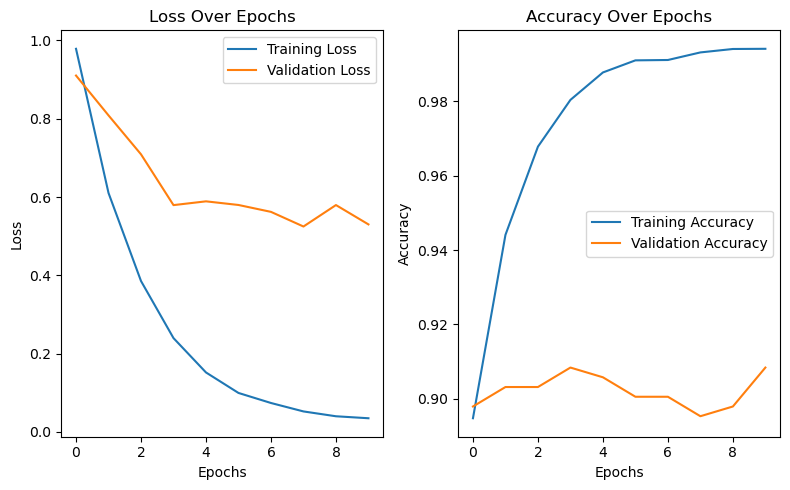


Final Training Loss: 0.0350
Final Validation Loss: 0.5302

Final Training Accuracy: 0.9941
Final Validation Accuracy: 0.9084


*** EVALUATING MODEL ON TEST SET ***


12/12 [==============================] - 2s 140ms/step - loss: 0.6923 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9064
{'loss': 0.6922516226768494, 'accuracy': 0.8713910579681396, 'precision': 0.8713910579681396, 'recall': 0.8713910579681396, 'auc': 0.9063935875892639}
Test Accuracy: 0.8713910579681396
Test Precision: 0.8713910579681396
Test Recall: 0.8713910579681396
Test Auc: 0.9063935875892639
*** INITIALISING RESULTS TABLE ***


In [14]:
# Train, plot, and evaluate the model
model_registry = bert_classifier.train_plot_and_evaluate(train_inputs=[X_train_ids, X_train_masks],
                                        train_labels=y_train,
                                        val_inputs=[X_val_ids, X_val_masks],
                                        val_labels=y_val,
                                        test_inputs=[X_test_ids, X_test_masks],
                                        test_labels=y_test,
                                        epochs=10,
                                        model_description="BERT (Pubmed) with pseudo-labelling",
                                        metrics_plot=['loss', 'accuracy'],
                                        metrics_eval=['accuracy', 'precision', 'recall', 'auc'])

**About these results**

As it can be seen, the results presented are slighly worse than the ones mentioned in the report. This variation can be justified by the fact that, here, we retrained and tested the pseudo labels and the model with a different, more recent dataset. 
Furthermore, one thing that was already mentioned in the report, but it's important to remember again, is the fact that this configuration for BERT model should be run with max_len = 400, in order for truncation not to happen. If access to cloud gpu services is possible, we highly recommend you to try to train the model again, but this time using max_len = 400 and see the results. 

**Note**: It's possible to save the entire model
(including architecture, weights, and training configuration) 
by using the method we developed called save_model,
and it's also possible to save model history too, using other method called save_history,
however here we are just saving the weights, using the method save_weights.

In [15]:
# Save only the model weights in HDF5 format
weights_save_path = "../models/bert_pubmed_weights.h5"
bert_classifier.save_weights(weights_save_path)

Weights saved at ../models/bert_pubmed_weights.h5.h5


### LGBM with TFIDF

In [12]:
# Initialize the LSGM classifier (default parameters are the hyperparameters chosen by the tuning process)
lgbm_classifier = LGBM_TFIDF_Classifier()

# Train the model
lgbm_classifier.train(train_df["text_processed"], train_df["relevant"])

# Save the model and vectorizer
#lgbm_classifier.save_model("../models/tfidf_vectorizer.joblib", "../models/lgbm_classifier.joblib")

# Evaluate the model
results = lgbm_classifier.evaluate(test_df["text_processed"], test_df["relevant"])

[LightGBM] [Info] Number of positive: 5931, number of negative: 14666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.845914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 502492
[LightGBM] [Info] Number of data points in the train set: 20597, number of used features: 18591
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.287955 -> initscore=-0.905339
[LightGBM] [Info] Start training from score -0.905339
Training completed.
True labels: {0, 1}
Predicted labels: {0, 1}


In [39]:
# Concat to the BERT results
results_metrics = {k: v for k, v in results.items() if k in ['accuracy', 'precision', 'recall', 'roc_auc']}
results_df_LGBM = pd.DataFrame(results_metrics, index=[0])
results_df_LGBM.rename(columns={'roc_auc':'test_auc', 'accuracy':'test_accuracy', 'recall':'test_recall', 'precision':'test_precision'}, inplace=True)
results_df_LGBM['model'] = 'LGBM with TF-IDF'
results_df_LGBM['training_time'] = 30
results_df_LGBM['n_epochs'] = None
results_df_LGBM['avg_epoch_time'] = None
model_registry = pd.concat([model_registry, results_df_LGBM])

## 6. Show Model Performance Results

For more details on the results of each model, check the training reports for deep learning models and the additional metrics available in the classifier scripts.

In [40]:
display(model_registry)

,model,training_time,n_epochs,avg_epoch_time,test_accuracy,test_precision,test_recall,test_auc
0,BERT (Pubmed) with pseudo-labelling,2967.967363,10,296.796736,0.871391,0.871391,0.871391,0.906394
0,LGBM with TF-IDF,30.000000,None,NaN,0.892388,0.892080,0.892388,0.883573
